# Spectra

## Spectral analysis of timeseries

Turbulence is associated with different scales, which interact in a complex manner and to investigate them spectra can be examined. Thereby, the measurements are transformed from time to frequency domain. The most common approach is to represent the timeseries with a series of sine and cosine function (with different frequencies), which is referred to as Fourier analysis. A numerical optimized way to calculate the Fourier transformation is to use Fast Fourier Transform (FFT, in rbase: `fft`). However, periodicity is not always a suitable assumption, such that other basis functions and approaches might be more applicable. With a wavelet transform information in time and frequency domain is retained and different wavelet basis functions (e.g., Morlet wavelets or Haar-wavelets) allow to represent localized and non-periodic behaviour (`WaveletComp::wt.image`). A very practical discrete wavelet transform is multiresolution decomposition (MRD, @Vickers2003, `Reddy::calc_mrd`), which is routinley applied in the analysis of eddy-covariance data (see details below). <br>
A related method used for flux calculations from eddy-covariance data is based on Ogives, that is a cumulative frequency distribution, i.e. the sum of the cospectral energy. @Sievers2015 developed an Ogive optimization, which allows to disentangle low frequency contributions on flux estimates. This approach is particular relevant under low-flux conditions, e.g. with changing signs in one averaging interval. The low frequency contributions are generally associated with non-local features, e.g. topography, while high-frequency contributions are local.

**Quick overview:** <br>
- Fast Fourier Transform FFT (rbase: `fft`, `spectrum`)
- Wavelets (`WaveletComp::wt.image`)
- Multiresolution decomposition MRD (`Reddy::calc_mrd`)
- Ogives (`agricolae::ogive.freq`)

In [1]:
#loading Reddy package
install.packages("../src/Reddy_0.0.0.9000.tar.gz",repos=NULL,source=TRUE,quiet=TRUE)
library(Reddy)

#ec data files
dir_in="../data/ec-data_10Hz_raw"
files=list.files(dir_in,full.names=TRUE)
nf=length(files)

i=8 #select a file
tmp=read.table(files[i],sep=",",header=T)

## FFT spectrum and comparison to theoretical spectra
The rbase function `spectrum` calculates the spectrum based on FFT and plots by default an associated periodigram. 

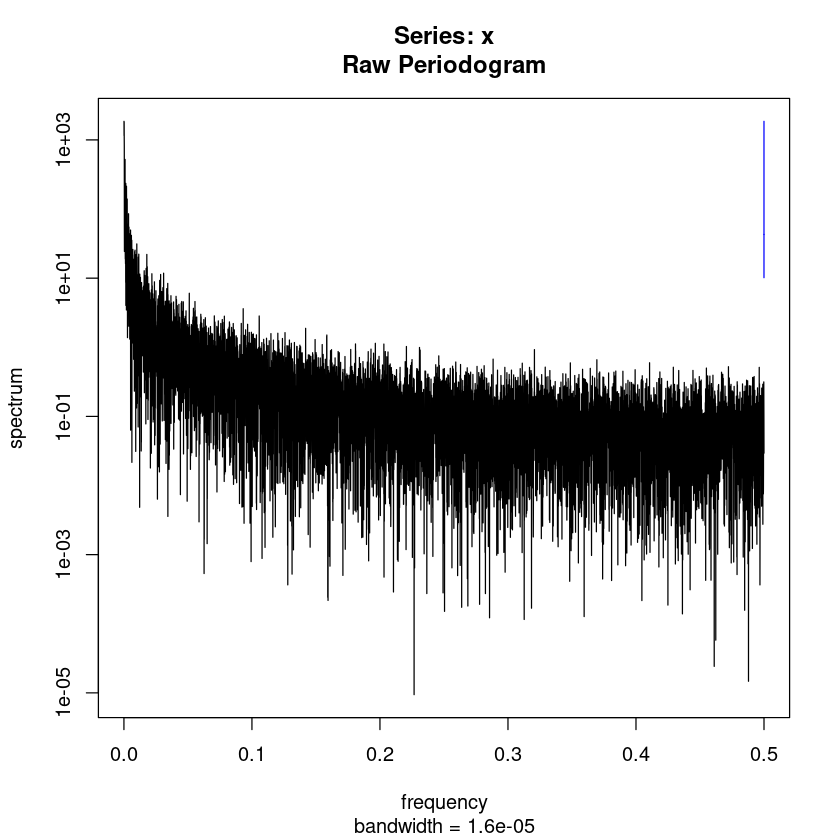

In [2]:
spectrum(tmp$u_m.s)

However, to systematically investigate spectral density and reduce the noise, it is recommended to apply binning (i.e., averaging over frequency intervals), which can be done with the function `Reddy::calc_spectrum` (as wrapper of `spectrum`). The resulting averaged spectra can then be compared to theoretical slopes. In homogeneous and isotropic turbulence a spectral slope of -5/3 follows from theoretical considerations (Kolmogorovs energy cascade), which is usually used as visual comparison. Deviations from this -5/3-slope indicate that either more energy (steeper slope) or less energy (weaker slope) is dissipated, which can have various reasons, e.g. turbulence anisotropy or energy injections.


Call:
lm(formula = log(sbin[, 2]) ~ bins[2:nbins])

Residuals:
     Min       1Q   Median       3Q      Max 
-2.20343 -0.08638  0.00209  0.21610  1.08777 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -3.9486     0.2669  -14.79 2.23e-16 ***
bins[2:nbins]  -2.7810     0.1064  -26.15  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6212 on 34 degrees of freedom
  (63 observations deleted due to missingness)
Multiple R-squared:  0.9526,	Adjusted R-squared:  0.9512 
F-statistic: 683.6 on 1 and 34 DF,  p-value: < 2.2e-16



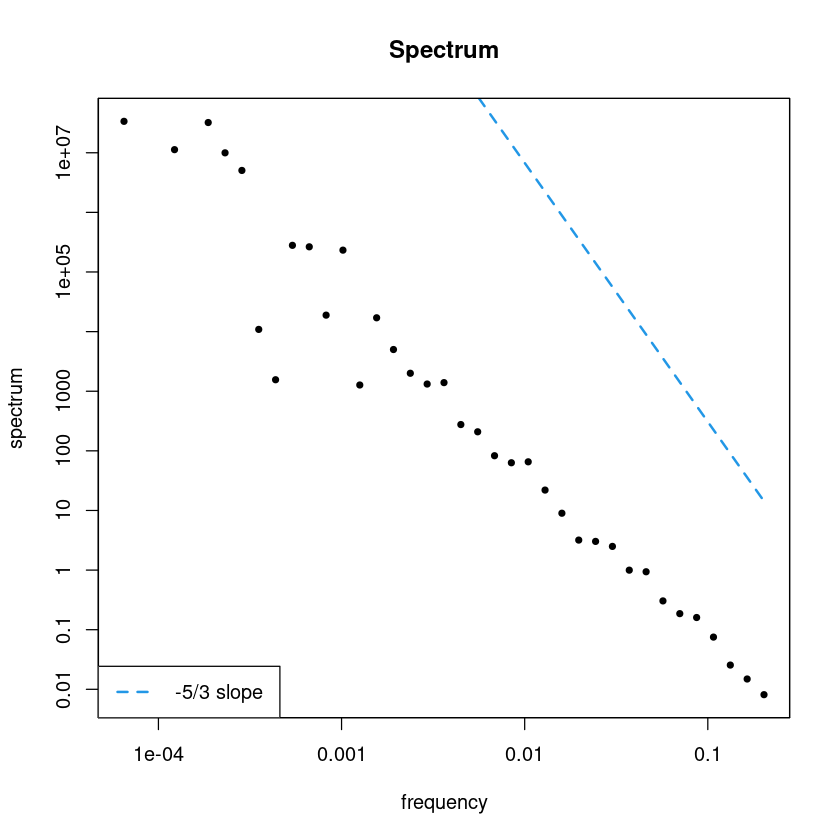

In [3]:
spectrum_u = calc_spectrum(tmp$u_m.s)

## Multiresolution decomposition (MRD)
Multiresolution decomposition (MRD) is a method to characterize the timescale dependence of variances (spectrum) or covariances (cospectrum) and to find scale gaps between turbulent and submeso-scale motions. It uses Haar wavelets, which have the advantage over Fourier analysis that no periodicity is assumed. For this, the time series is step-by-step cut in half, as visualized in the figure.

<img src="../figures/schema/mrd_schema.png" width=600 />


### Calculating multiresolution decomposition with `calc_mrd`

In [4]:
#cospectra
mrd_uw=calc_mrd(tmp$u_m.s,tmp$w_m.s,time_res=0.1) #momentum flux
mrd_Tw=calc_mrd(tmp$T_degC,tmp$w_m.s,time_res=0.1) #sensible heat flux

#spectra
mrd_ww=calc_mrd(tmp$w_m.s,tmp$w_m.s,time_res=0.1) #vertical veloctiy
mrd_TT=calc_mrd(tmp$T_degC,tmp$T_degC,time_res=0.1) #temperature

The function returns a dataframe containing index, exponent $m$, scale (i.e. $2^{m}$), time [s], mean, median, 25% and 75% quartiles as columns. The number of rows is given by $M$ fulfilling $2^M \le $ #measurements.

In [5]:
#look into output
mrd_uw

index,m,scale,time,mean,median,q25,q75
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14,16384,1638.4,2.009888e-03,6.411861e-05,-5.739598e-03,7.411443e-03
2,13,8192,819.2,3.723193e-03,3.046532e-04,-7.508746e-03,1.040180e-02
3,12,4096,409.6,5.007376e-03,6.024576e-04,-9.401348e-03,1.487008e-02
4,11,2048,204.8,5.831290e-03,6.054180e-04,-9.164119e-03,1.592909e-02
5,10,1024,102.4,9.752098e-03,1.325413e-03,-6.967310e-03,1.938746e-02
6,9,512,51.2,1.090534e-02,2.818075e-03,-4.432612e-03,1.858083e-02
7,8,256,25.6,1.465273e-02,3.577008e-03,-3.271827e-03,2.213298e-02
8,7,128,12.8,1.157982e-02,3.560662e-03,-6.819690e-03,1.801111e-02
9,6,64,6.4,9.264997e-03,5.478194e-04,-8.774036e-03,9.014596e-03


### Plotting multiresolution decomposition with `plot_mrd`

`plot_mrd` takes an object returned by `calc_mrd` and plots mean, median and quartiles versus time.

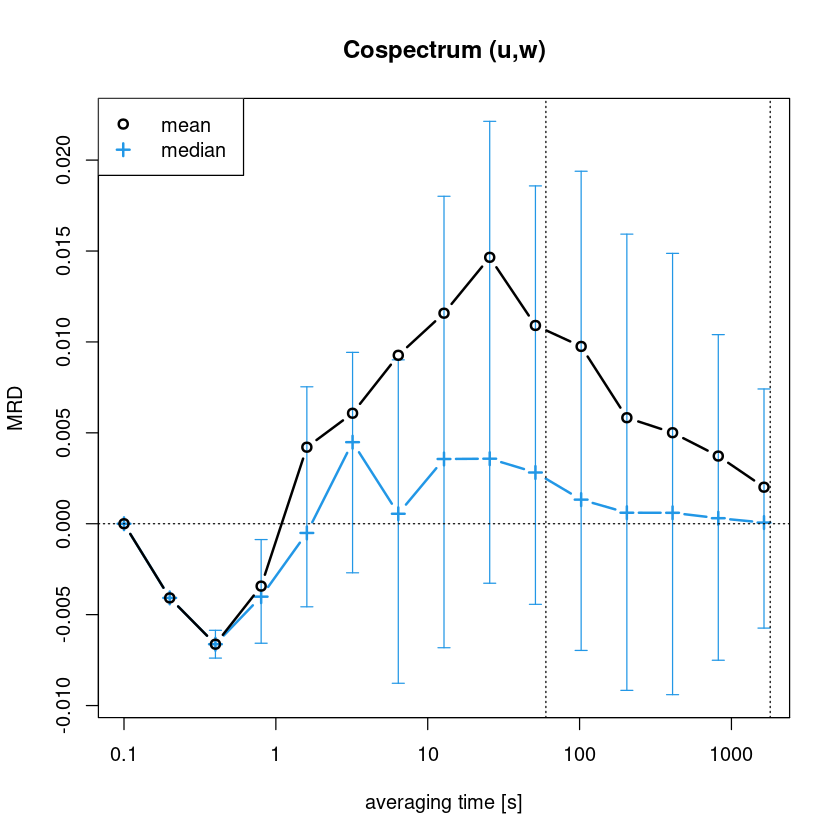

In [6]:
plot_mrd(mrd_uw, main="Cospectrum (u,w)")

In [7]:
#plot_mrd(mrd_Tw, main="Cospectrum (T,w)")

In [8]:
#plot_mrd(mrd_ww, main="Spectrum (w,w)")

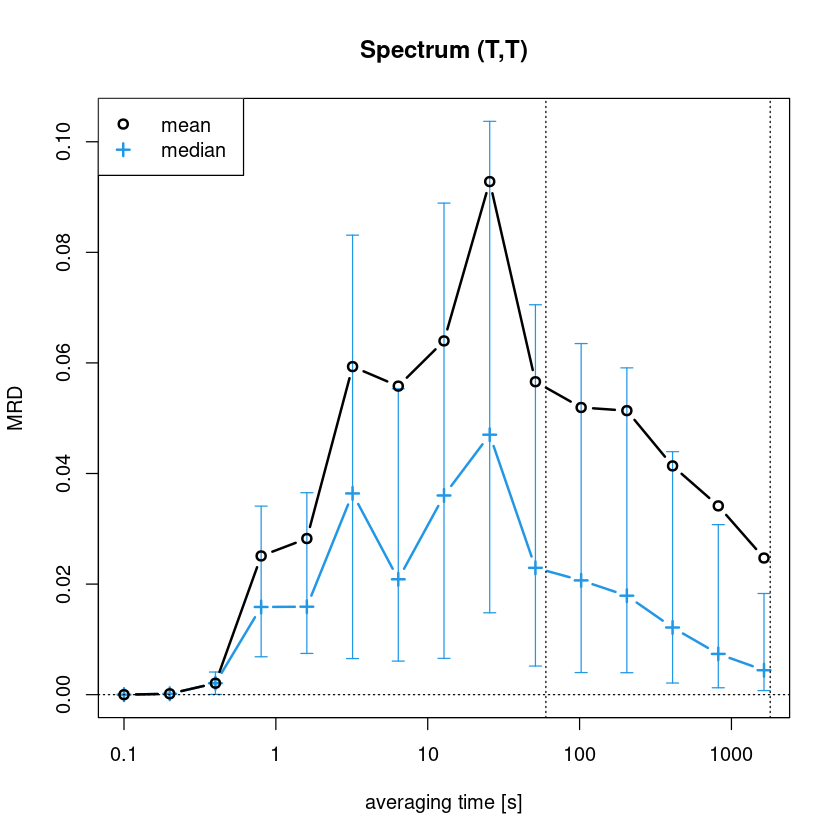

In [9]:
plot_mrd(mrd_TT, main="Spectrum (T,T)")

Composite MRDs can be created by averaging over several MRDs (also possible to distinguish different flow regimes, e.g., based on the stability parameter `calc_zeta`) and can be used to find long-term characteristic (e.g., scale gaps). Scale(s) gap(s) are defined as the the zero-crossings of the spectrum or cospectrum (larger than the first zero-crossing at the measurement frequency itself).